In [31]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap

In [32]:
data = pd.read_csv('ndtv_data_final.csv')

In [33]:
data.head()

,Unnamed: 0,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,...,Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,...,48.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,...,64.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
3,3,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,828,1792,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
4,4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,1080,2340,8,...,12.0,32.0,Android,Yes,Yes,Yes,1,No,No,49990


In [34]:
data = data.drop(['Unnamed: 0'], axis=1)
data = data.convert_dtypes()

In [35]:
px.box(data, 'Price', hover_name = 'Model')

In [36]:
px.box(data.groupby('Brand', as_index=False).Price.mean(), 'Price', hover_name = 'Brand')

In [37]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [38]:
train.columns

Index(['Name', 'Brand', 'Model', 'Battery capacity (mAh)',
       'Screen size (inches)', 'Touchscreen', 'Resolution x', 'Resolution y',
       'Processor', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera',
       'Front camera', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS',
       'Number of SIMs', '3G', '4G/ LTE', 'Price'],
      dtype='object')

In [39]:
brand_mapping_mean = train.groupby('Brand').Price.mean().to_dict()
brand_mapping_std = train.groupby('Brand').Price.std().to_dict()

In [40]:
train['brand_mean'] = train['Brand'].map(brand_mapping_mean)
train['brand_std'] = train['Brand'].map(brand_mapping_std)

In [41]:
train.pop('Name')
train.pop('Brand')
train.pop('Model')

865                   S1
1289        Lumia 950 XL
394     ZenFone 2 Deluxe
731            Frames S9
54                     3
              ...       
1095       Canvas Fire 5
1130              Vibe C
1294                Y15S
860                 Q626
1126     Cloud String HD
Name: Model, Length: 1087, dtype: string

In [42]:
y_train = train.pop('Price')

In [43]:
cates = train.select_dtypes(exclude=['int64', 'float64']).columns

In [44]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_alpha': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 0.25, 0.5, 1.0],
    'tree_method': ['hist'],
    #'enable_categorical': [True],
    'n_jobs': [-1],
    'random_state': [42]
}

In [45]:
for c in train.columns:
    if c not in cates:
        train[c] = train[c].astype('float')
    if c in cates:
        train[c] = train[c].astype('category')

In [46]:
model = XGBRegressor()

In [47]:
train = pd.get_dummies(train, columns=cates, drop_first='if_binary')

In [48]:
clf = RandomizedSearchCV(model, param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1).fit(train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\bhatn\anaconda3\envs\modsk\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [49]:
bestmodel = XGBRegressor(**clf.best_params_).fit(train, y_train)

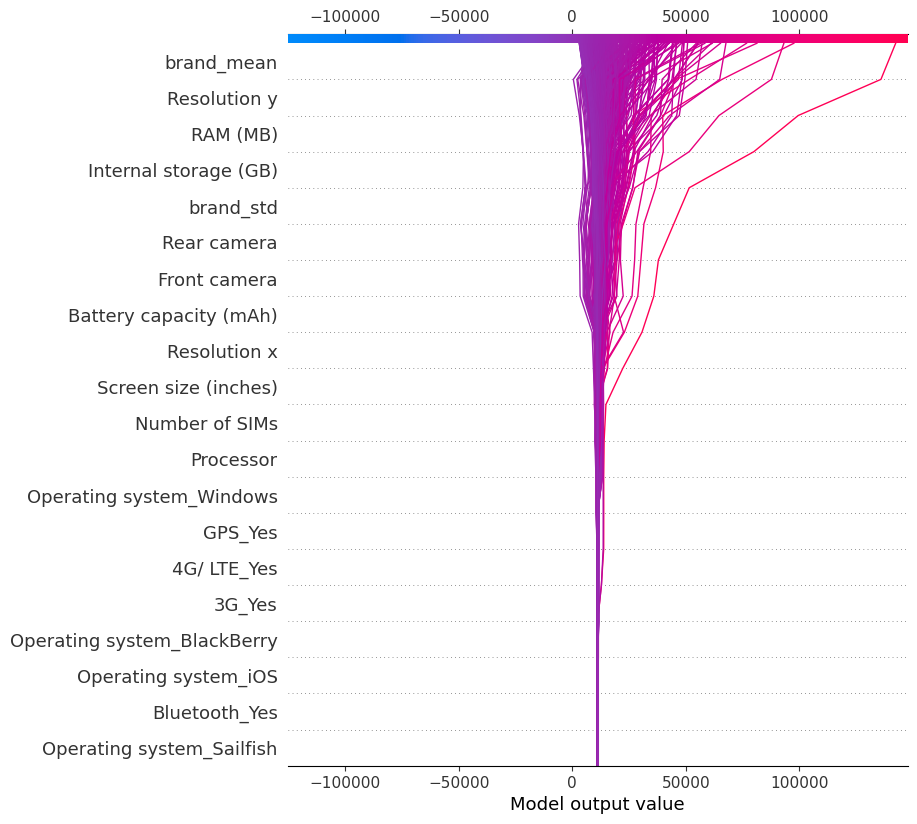

In [63]:
explainer = shap.TreeExplainer(bestmodel)
shap_values = explainer.shap_values(train)
shap.decision_plot(explainer.expected_value, shap_values, train.iloc[0,:])

In [51]:
y_test = test.pop('Price')

In [52]:
test['brand_mean'] = test['Brand'].map(brand_mapping_mean)
test['brand_std'] = test['Brand'].map(brand_mapping_std)

In [53]:
test.pop('Name')
test.pop('Brand')
test.pop('Model')

51       iPhone 7 Plus
1100         Aqua View
1312           Cloud V
514           Bingo 21
1074               A32
             ...      
924             i5 Pro
573          Lumia 525
243          Xperia Z1
945                 N2
638     Galaxy Note 10
Name: Model, Length: 272, dtype: string

In [54]:
for c in test.columns:
    if c not in cates:
        test[c] = test[c].astype('float')
    if c in cates:
        test[c] = test[c].astype('category')

In [55]:
test = pd.get_dummies(test, columns=cates, drop_first='if_binary')

In [60]:
for x in [x for x in train.columns if x not in test.columns]:
    test[x] = np.zeros(test.shape[0])

In [61]:
bestmodel.score(test, y_test)

0.6843541786984355

c:\Users\bhatn\anaconda3\envs\modsk\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

c:\Users\bhatn\anaconda3\envs\modsk\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



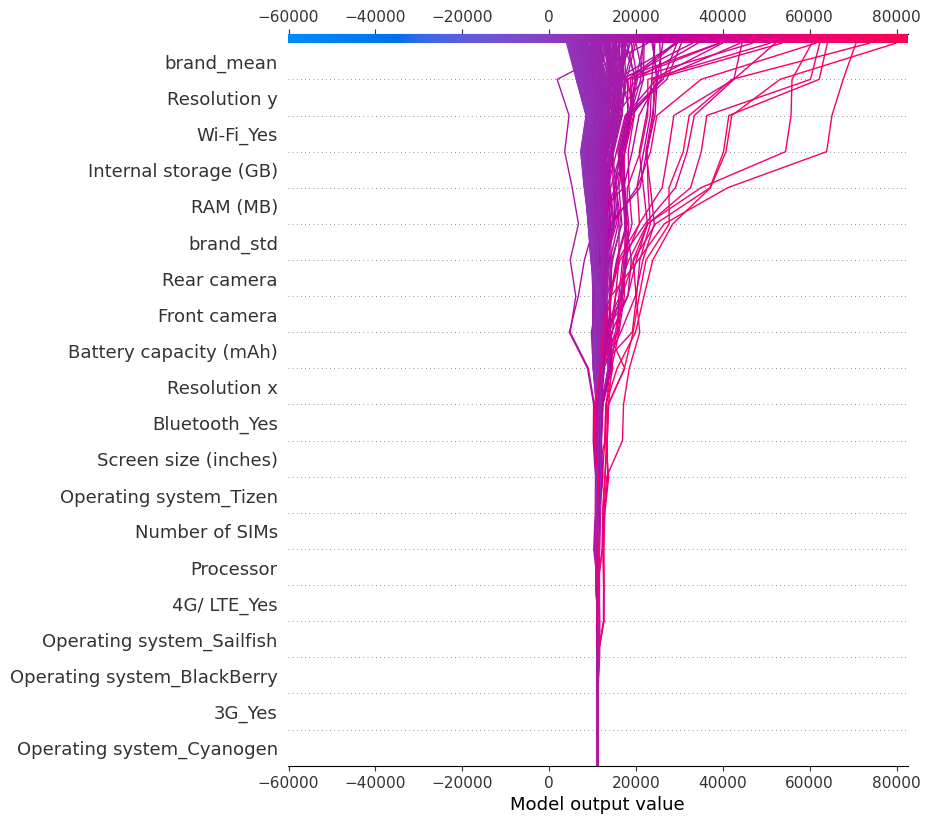

In [72]:
explainer = shap.TreeExplainer(bestmodel)
shap_values = explainer.shap_values(test)
shap.decision_plot(explainer.expected_value, shap_values, test.iloc[0,:])